# Finding a Model

We start with imports and reading data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MultiLabelBinarizer, FunctionTransformer, StandardScaler
from sklearn.linear_model import SGDRegressor, Lasso, LinearRegression, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from Plots import plot_quantiles, plot_linear_relation, plot_categories_mean, plot_multilabel_categories_mean
from CustomExtractors import extract_numbers, extract_rating

m_cast = pd.read_csv('./data/Movie Cast.csv')
m_data = pd.read_csv('./data/Movie Data.csv')

print(m_cast.shape)
m_cast.head()

(203333, 4)


,Movie,Type,Name,Role
0,"10,000 B.C.",Actors,Steven Strait,D'Leh
1,"10,000 B.C.",Actors,Camilla Belle,Evolet
2,"10,000 B.C.",Actors,Cliff Curtis,Tic-Tic
3,"10,000 B.C.",Actors,Reece Ritchie,Moha
4,"10,000 B.C.",Actors,Marco Khan,One Eye


In [2]:
print(m_data.shape)
m_data.head(10)

(5691, 16)


,Movie,Budget (thousands of $),Domestic Box Office Revenue (thousands of $),International Box Office Revenue (thousands of $),MPAA Rating,Running time,Franchise,Original source,Genre,Production method,Type,Production companies,Production country,Languages,Distributor,Release year
0,10 Questions for the Dalai Lama,NaN,224.5,260.0,Not Rated,NaN,NaN,Real Life Events,Documentary,Live Action,Factual,NaN,United States,English,Monterey Media,2007
1,10th & Wolf,8000.0,54.7,89.1,Not Rated,NaN,NaN,Real Life Events,Drama,Live Action,Dramatization,NaN,United States,English,ThinkFilm,2006
2,2006 Academy Award Nominated Short Films,NaN,335.1,NaN,Not Rated,NaN,Academy Award Short Film Nominations,Compilation,Thriller,Multiple Production Methods,Multiple Creative Types,NaN,United States,English,Magnolia Pictures,2007
3,24 Hour Party People,NaN,1169.0,2435.9,"R for strong language, drug use and sexuality",NaN,NaN,Real Life Events,Drama,Live Action,Dramatization,NaN,United States,English,MGM,2002
4,39 Pounds of Love,NaN,28.1,2.1,Not Rated,NaN,NaN,Real Life Events,Documentary,Live Action,Factual,NaN,United States,English,Balcony Releasing,2005
5,8 Films to Die For,NaN,2310.7,NaN,Not Rated,NaN,8 Films to Die For,Compilation,Horror,Live Action,Multiple Creative Types,NaN,United States,English,Freestyle Releasing,2006
6,A Good Woman,NaN,223.1,5852.6,"PG for thematic material, sensuality and langu...",NaN,NaN,Play,Drama,Live Action,Historical Fiction,NaN,United States,English,Lionsgate,2005
7,A Guy Thing,20000.0,15543.9,1886.7,"PG-13 for language, crude humor, some sexual c...",101 minutes,NaN,Original Screenplay,Romantic Comedy,Live Action,Contemporary Fiction,NaN,United States,English,MGM,2003
8,Abandon,25000.0,10719.4,1500.0,"PG-13 for drug and alcohol content, sexuality,...",NaN,NaN,Original Screenplay,Thriller,Live Action,Contemporary Fiction,NaN,United States,English,Paramount Pictures,2002
9,Absurdistan,NaN,39.7,NaN,Not Rated,NaN,NaN,NaN,Comedy,NaN,NaN,NaN,United States,English,First Run Features,2009


In [3]:
target_cols = [
    'Domestic Box Office Revenue (thousands of $)', 
    'International Box Office Revenue (thousands of $)'
]
budget = 'Budget (thousands of $)'
clean_target_cols = m_data[target_cols].fillna(0)

y = clean_target_cols.iloc[:,0] + clean_target_cols.iloc[:,1]
print(f"{y.mean()} $")

84372.29247179757 $


In [4]:
X = m_data.drop(target_cols, axis=1)

## Adding features

### Numerical

In [5]:
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

### Running time

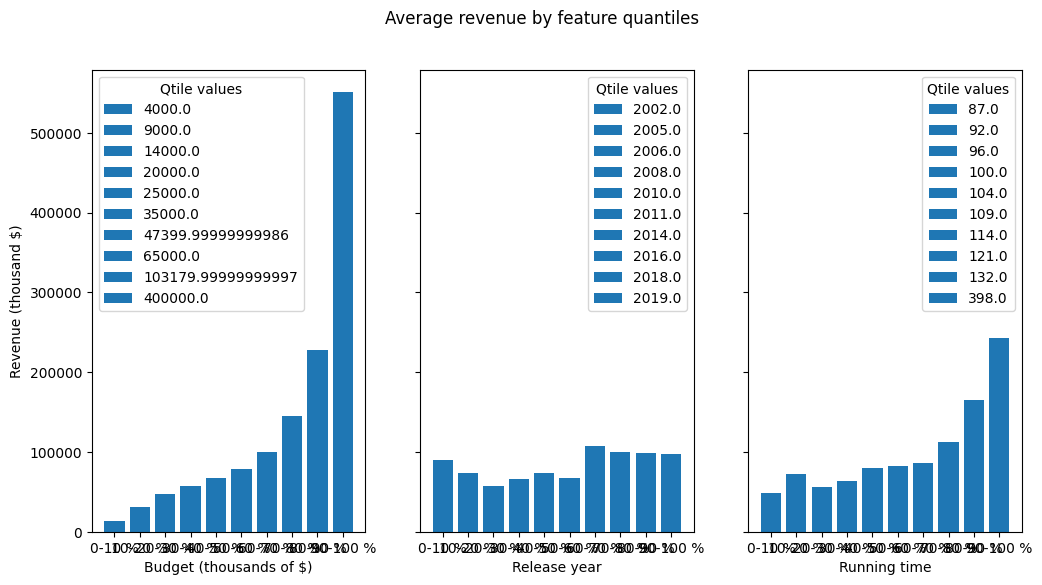

In [6]:
num_extract_cols = [
    'Running time'
]

X_proc = extract_numbers(X, num_extract_cols)
plot_quantiles(X_proc,
               y, 
               numerical_cols + num_extract_cols,
               "Average revenue by feature quantiles",
               "Revenue (thousand $)",
               parts=10)

Looks like in numerical features, the year is not relevant with Revenue. In fact, after 2011 the revenues are higher, but decreasing. Still, there is a consistent average of $100M in revenue.

Budget and Running time seem to affect Revenue strongly. The movies over 103M in budget make an average of over 500M in Revenue. Also we see that movies over 114 min long make much more money than shorter ones.

### Rating

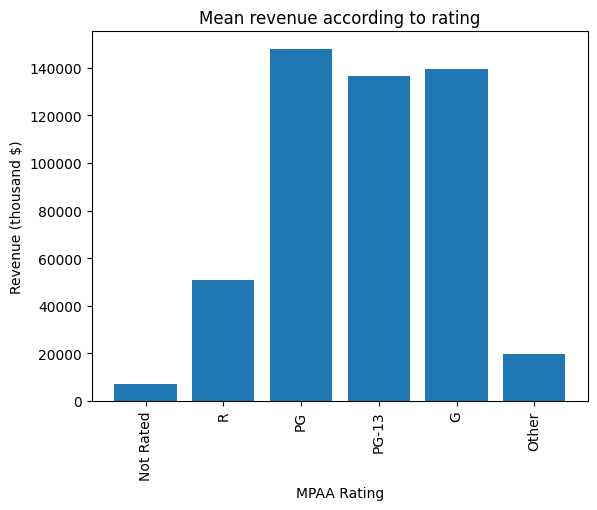

In [7]:
rating_cols = [
    'MPAA Rating'
]

x = extract_rating(X, rating_cols)['MPAA Rating']
x.fillna('Not Rated', inplace=True)
plot_categories_mean(
    x,
    y,
    'Mean revenue according to rating',
    'Revenue (thousand $)'
)

Looks like the rating is extremely important in determining revenue. In particular, it looks very important to have a rating of G, PG or PG-13. Films rated R make barely over 1/3 of the revenue as the other films. And NC-17 make even less money.

### Franchise

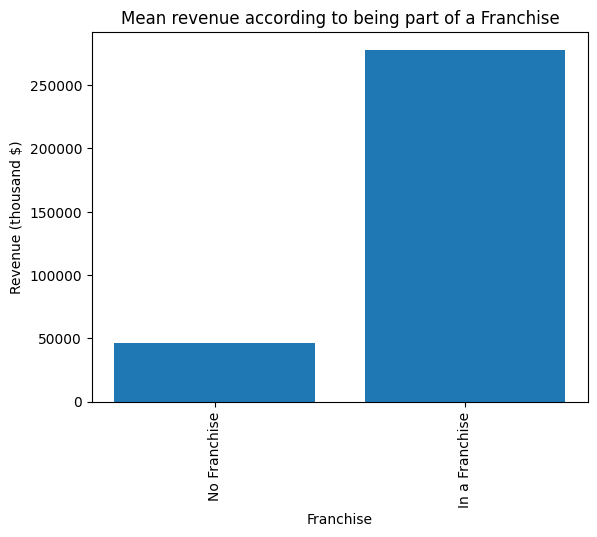

In [8]:
x = X['Franchise'].copy()
x = x.isnull().map(lambda noFranchise: 'No Franchise' if noFranchise else 'In a Franchise')

plot_categories_mean(
    x,
    y,
    'Mean revenue according to being part of a Franchise',
    'Revenue (thousand $)',
)

Looks like beign part of a Franchise is a sure way of making a lot of money. This might be survivorship bias, though, as unsuessful movies will not develop into a franchise.

### Genre, Original source, Production method, Type and Distributor

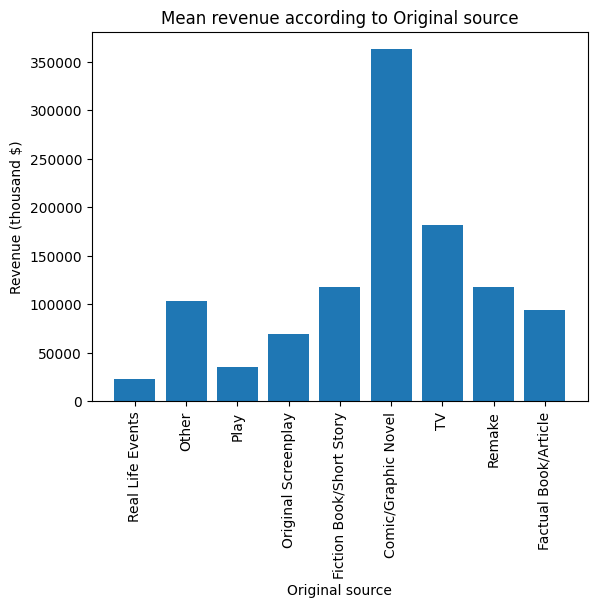

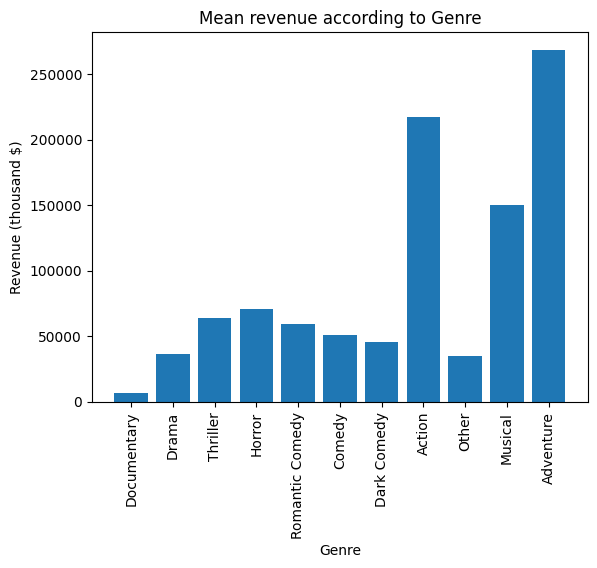

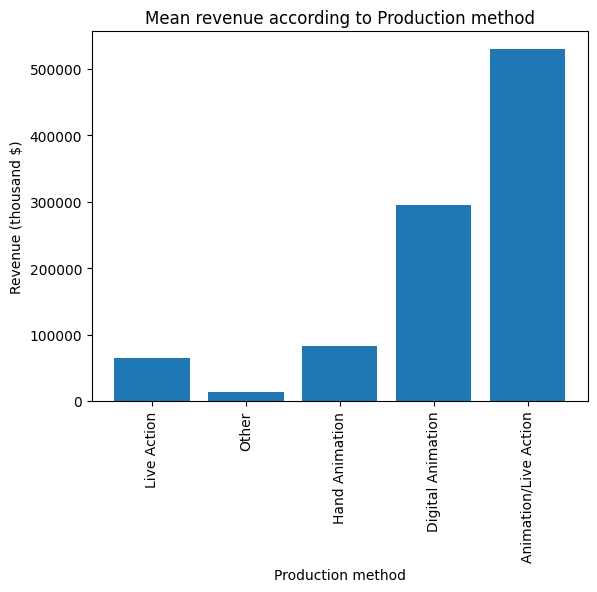

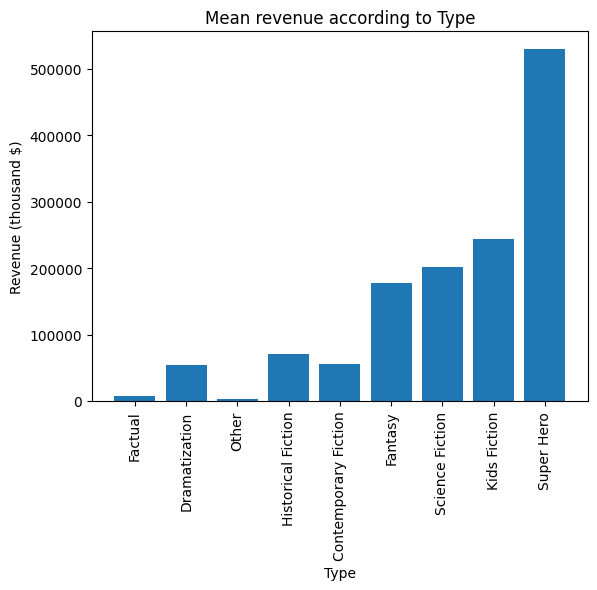

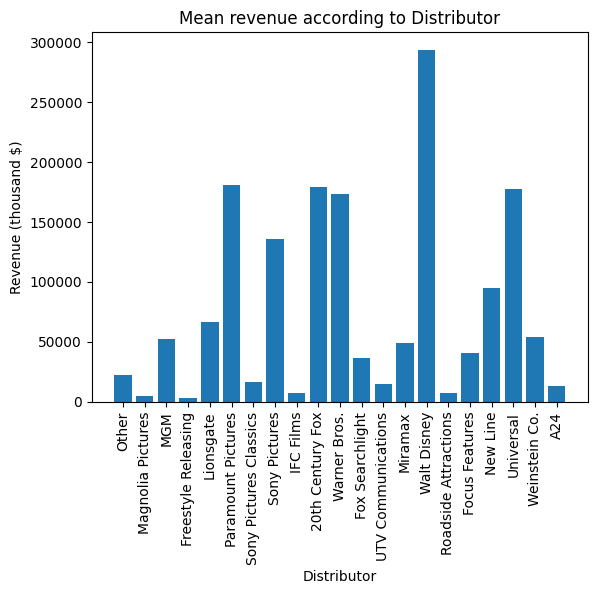

In [9]:
cols = [
    'Original source',
    'Genre',
    'Production method',
    'Type',
    'Distributor'
]

for col in cols:
    x = X[col].copy()
    
    plot_categories_mean(
        x,
        y,
        f'Mean revenue according to {col}',
        'Revenue (thousand $)',
    )

What a surprise, the movies making the most revenue are Comic Book Super Hero Action movies filmed in a mix of Animation and Live Action. Not a surprise considering the success of MCU. They occupy 9 places of the 30 top grossing films.

Also, we can see that the Big 5 studios (Disney \[including 20th c. Fox], Warner Bros \[including New Line], Paramount, Universal and Sony \[including Columbia]) are the ones making more money. But this can be a source of data leakage, as these companies might be less risk-averse and only distribute movies that will make a profit. Or it can also be that they are able to muscle their movies into theaters much better.

### Multilabel categorical features

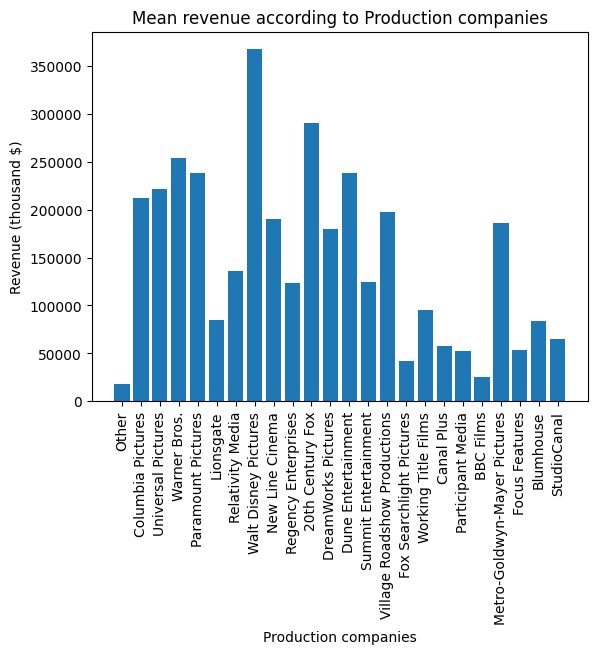

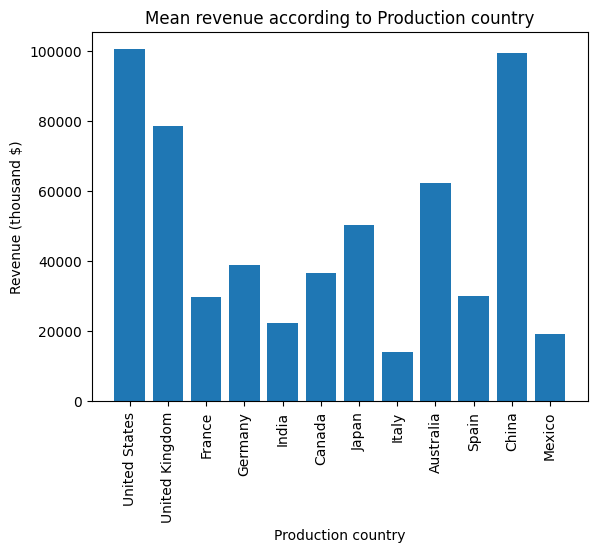

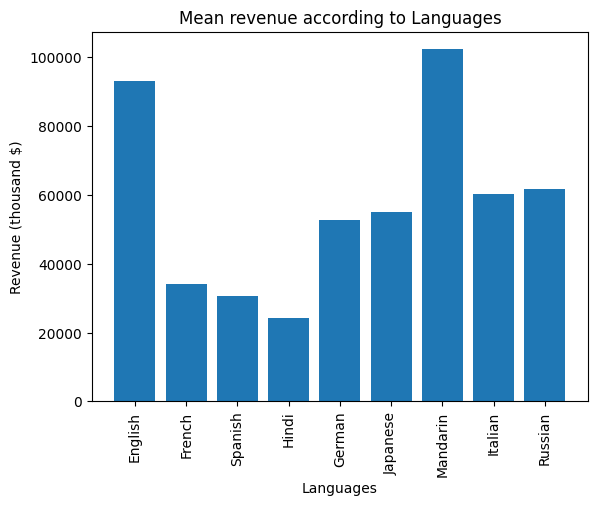

In [10]:

cols = [
    'Production companies',
    'Production country',
    'Languages'
]

for col in cols:
    x = X[col].copy()
    other_label = 'Other'
    min_rel_cat_count = 50
    plot_multilabel_categories_mean(
        x,
        y,
        f'Mean revenue according to {col}',
        'Revenue (thousand $)'
    )

### Model

In [11]:
# Preprocessing for numerical data
numerical_cols = [budget]

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean'))
])

In [12]:
# Preprocessing for numerical data that needs extraction
number_extractor_transformer = Pipeline(steps=[
    ('extractor', FunctionTransformer(extract_numbers)),
    ('imputer', SimpleImputer(strategy='median')),
])

In [13]:
# Rating
orders = [['Not Rated', 'NC-17', 'R', 'PG-13', 'PG', 'G']]

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Not Rated')),
    ('extractor', FunctionTransformer(extract_rating)),
    #('encoder', OrdinalEncoder(categories=orders))
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [14]:
# Franchise
binary_cols = ['Franchise']

binary_transformer = Pipeline(steps=[
    ('binarizer', FunctionTransformer(lambda data: data.notnull()))
])

In [15]:
# Categories
simple_cat_cols = [
    'Original source',
    'Genre',
    'Production method',
    'Type',
    'Distributor'
]

simple_categorical_cols_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', min_frequency=50))
])

In [16]:
import itertools

# Multilabel categories
categorical_cols_multilabel = [
    'Production companies', 'Production country', 
    'Languages'
]

def process_multilabel(data):
    new_data = pd.DataFrame(data.copy())
    other_label = 'Other'
    for col in new_data.columns:
        x = new_data[col]
        labels = pd.Series(itertools.chain.from_iterable(x.map(lambda a: a.split(', ') if isinstance(a, str) else [other_label])))
        cats = labels.value_counts().loc[labels.value_counts() >= 50].index
        for cat in cats:
            data_cat = x.astype(str).str.contains(cat).map(lambda a: 1 if (a or (not a and (cat == other_label))) else 0)
            data_cat.rename(f"{col}_{cat}", inplace=True)
            print(col,data_cat)
            new_data = pd.concat([new_data, data_cat])
        new_data.drop(col, inplace=True)
    return new_data
            

multilabel_categorical_cols_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('splitter', FunctionTransformer(process_multilabel))
])

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('num_extract', number_extractor_transformer, num_extract_cols),
        ('ordinal', ordinal_transformer, rating_cols),
        ('binary', binary_transformer, binary_cols),
        ('cat_simp', simple_categorical_cols_transformer, simple_cat_cols),
        #('cat_multi', multilabel_categorical_cols_transformer, categorical_cols_multilabel)
    ])

"""
model = ElasticNet(
    alpha=1e-4,
    max_iter=int(1e6),
    tol=1,
)
"""
model = RandomForestRegressor()

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

In [18]:
feat_cols = [
    budget,
    'Release year',
    'Running time',
    'MPAA Rating',
    'Franchise',
    'Original source',
    'Genre',
    'Production method',
    'Type',
    'Distributor',
    'Production companies',
    'Production country',
]
X = m_data[feat_cols]

# Divide data into training and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.8,
    test_size=0.2,
)

In [19]:
dum_model = DummyRegressor(strategy='mean')
dum_model.fit(X_train, y_train)

y_pred = dum_model.predict(X_test)

dum_sq_error = mean_squared_error(y_test, y_pred, squared=False)
dum_sq_error

168250.0933536701

In [20]:
# Check CV score again

def split(X, y, train_fraction):
    train_size = int(train_fraction * X.shape[0])

    X_train = X.sample(train_size)
    X_test = X[~X.index.isin(X_train.index)]
    y_train = y[X_train.index]
    y_test = y[~X.index.isin(X_train.index)]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split(X,y,.8)

In [21]:
my_pipeline.fit(X_train, y_train)

col_cat = my_pipeline['preprocessor'].transformers_[4][1][1].get_feature_names_out()
new_feats = np.concatenate([numerical_cols, num_extract_cols, rating_cols, binary_cols, col_cat])

y_pred = my_pipeline.predict(X_test)
score = my_pipeline.score(X_test, y_test)

## WHY IS IT NEGATIVE?
cv_score = cross_val_score(my_pipeline,X,y,cv=5,n_jobs=8)

mse = mean_squared_error(y_test, y_pred, squared=False)

print(f"""
Score: {score}
CVScore: {cv_score.mean()}
CVScores: {cv_score}
Model MSE: {mse}
Difference with Dummy MSE: {'{:.3}'.format((mse) / dum_sq_error * 100)}%
    """)
#Intercept: {model.intercept_}


Score: 0.7057046782547481
CVScore: 0.5764445331422253
CVScores: [0.21845107 0.70542262 0.63307579 0.6983303  0.62694289]
Model MSE: 91776.68462900083
Difference with Dummy MSE: 54.5%
    


In [22]:
coefs = pd.DataFrame(np.vstack((new_feats, model.coef_)).transpose())
coefs.columns = ['Feature', 'Coeficient (thousands of $)']
coefs

AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

Score: 0.6274265130284882

CVScore: 0.39133216774733104

* ElasticNet (alpha=1e-4):
    * Model MSE: 121686.96669841874
    * Difference with Dummy SE: 60.0%
* LinearRegression:
    * Model MSE: 133392.90200052838
    * Difference with Dummy SE: 65.8%
* Lasso:
    - Model MSE: 140980.34469900327
    - Difference with Dummy SE: 69.6%
* SGD Regressor (eta0 = 1e-12, learning_rate="constant"):
    * Model MSE: 150006.9174702464
    * Difference with Dummy SE: 74.0%

## Actors overperforming

In [23]:
actor_movies = m_cast.loc[m_cast.Type == 'Actors'].groupby('Name').Movie.unique()
actor_movies = actor_movies.loc[actor_movies.map(len) >= 10]

def movies_to_mean_overperformance(movies):
    predicted_revenue = my_pipeline.predict(X[m_data.Movie.isin(movies)])
    real_revenue = y.loc[m_data.Movie.isin(movies)]
    return (real_revenue-predicted_revenue).mean()

actors_revenue = actor_movies.map(movies_to_mean_overperformance).to_frame()
actors_revenue.rename(columns={'Movie': 'Mean overperformance'}, inplace=True)
actors_revenue.sort_values('Mean overperformance', ascending=False)

,Mean overperformance
Name,
Lori Alan,139650.233396
Sterling K. Brown,114477.903356
Jess Harnell,101368.336471
Karen Gillan,98425.294491
Josh Gad,92344.152468
...,...
Sean Hayes,-50590.462709
Ron Perlman,-51959.592125
Mackenzie Crook,-51977.372923


## Staff overperforming

In [24]:
staff_movies = m_cast.loc[m_cast.Type == 'Production crew'].groupby('Name').Movie.unique()
staff_movies = staff_movies.loc[staff_movies.map(len) >= 10]

def movies_to_mean_overperformance(movies):
    predicted_revenue = my_pipeline.predict(X[m_data.Movie.isin(movies)])
    real_revenue = y.loc[m_data.Movie.isin(movies)]
    return (real_revenue-predicted_revenue).mean()

staffs_revenue = staff_movies.map(movies_to_mean_overperformance).to_frame()
staffs_revenue.rename(columns={'Movie': 'Mean overperformance'}, inplace=True)
staffs_revenue.sort_values('Mean overperformance', ascending=False)

,Mean overperformance
Name,
Janet Healy,165016.636625
Ben Burtt,154143.489948
Stuart Wilson,131064.514212
James Cameron,114794.956423
Colin Wilson,107689.842022
...,...
Ted Elliott,-72400.246037
Terry Rossio,-72400.246037
Penny Rose,-77311.467244
